In [86]:
import pandas as pd
import numpy as np
import metrics

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
%matplotlib inline

import preprocessing

In [203]:
!time g++ -Wall -std=c++11 -O3 src/*.cpp -o ./bin/sgd


real	0m3.913s
user	0m3.694s
sys	0m0.188s


In [205]:
!time ./bin/sgd data/mrh nbsinINC.cfg

Loading config file : data/mrhnbsinINC.cfg
Loading config file : OK. 
Fit Model...
0 : rmse train=0.878517, test=0.878362) | gini(train=0.0653161, test=0.104811)
10000000 : rmse train=0.0437915, test=0.0440351) | gini(train=0.317539, test=0.232743)
20000000 : rmse train=0.0437874, test=0.0440358) | gini(train=0.320298, test=0.201898)
30000000 : rmse train=0.0438327, test=0.0440932) | gini(train=0.328561, test=0.229431)
40000000 : rmse train=0.0437783, test=0.0440251) | gini(train=0.326801, test=0.227731)
^C


mean: 0.001954 0.001923
rmse: 0.043919
gini: 0.27834176484235684
deviance: 9.765080994610509


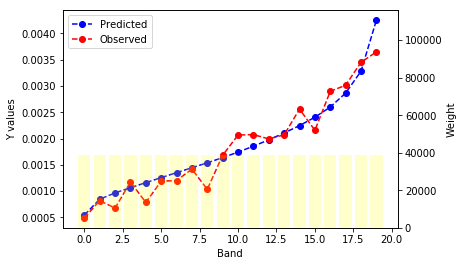

In [192]:
df = pd.read_csv("./data/results.csv")
print('mean:', round(np.sum(df.prediction) / np.sum(df.exposure), 6), round(np.sum(df.target) / np.sum(df.exposure), 6))
print('rmse:', round(metrics.root_mean_square_error(df.target, df.prediction, df.exposure), 6))
print('gini:', metrics.gini_emblem_fast(df.target, df.prediction, df.exposure))
print('deviance:', np.log(metrics.poisson_deviance(df.target, df.prediction, df.exposure)))
metrics.plot_lift_curve(df.target, df.prediction, df.exposure, n_band=20)

In [181]:
metadata = preprocessing.Metadata("data", "mrh")
metadata.load()

Loaded metadata from  data/mrh/metadata.json


In [182]:
n = metadata.size
p = metadata.count_features()
def load_data(file_path, dtype='int32', shape=None):
    return np.memmap(file_path, dtype=dtype, shape=shape)

data = load_data(metadata.get_feature_filename(), dtype=np.dtype('u1'), shape=(n, p))

In [183]:
df_coeffs = pd.read_csv('data/mrh/coeffs.csv').as_matrix()
df_coeffs = np.exp(df_coeffs)

def get_coeffs(feature_range):
    return df_coeffs[1 + np.array(feature_range)]    

In [184]:
test_data = data[df.row,:]

In [185]:
df.target.sum()

1483

In [ ]:
def plot_relativities(df, feature, idx, modalities):
    try:
        modalities = [float(m) for m in modalities]
        if sum([m - int(m) for m in modalities]) == 0:
            modalities = [int(m) for m in modalities]
    except:
        pass
    
    df['f'] = test_data[:, idx]

    m = df.target.mean()
    relativity = df.groupby(['f']).agg({'exposure': 'sum', 'target': 'mean', 'prediction': 'mean'})
    relativity.target /= m
    relativity.prediction /= m
    relativity['one'] = 1
    relativity['modalities'] = modalities
    relativity['coeffs'] = get_coeffs(metadata.get_feature_range(feature))
    if(relativity['coeffs'].sum() == relativity['coeffs'].count()):
        return
    relativity = relativity.sort_values('modalities')
    size = relativity.prediction.size
    ar = np.arange(size)
    
    max_exposure = relativity.exposure.max()
    
    fig, ax1 = plt.subplots(figsize=(10, 8))

    ax1.bar(ar, relativity.exposure, color='#f7f5a3')
    ax1.set_ylim(ymax=max_exposure * 3)
    ax1.set_xticks(ar)
    ax1.set_xticklabels(labels=relativity.modalities)
  
    ax2 = ax1.twinx()
    ax2.set_title(feature)
    ax2.plot(ar, relativity.prediction, color="#0f600e")
    ax2.plot(ar, relativity.target, color="#c242f4")
    ax2.plot(ar, relativity.coeffs, color="#93ff9e",marker="^")
    ax2.axhline(y=1, color='black', linewidth=1, linestyle="dotted")
    ax2.set_ylim(ymin=0)
    
    plt.show()
    
for f in metadata.features:
    try:
        plot_relativities(df, f, metadata.get_feature_index(f), metadata.get_modalities(f))
    except:
        print('Error ploting relativity chart for ', f)

In [210]:
a = (np.random.rand(20) < 0.5) * 1

In [211]:
a.var()

0.22749999999999998

In [216]:
a.mean()

0.35

In [218]:
(a*a).mean()

0.35